In [ ]:
!pip install transformers==2.11.0

     |████████████████████████████████| 675kB 5.0MB/s 
     |████████████████████████████████| 3.8MB 22.0MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
     |████████████████████████████████| 1.1MB 55.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=df01d6df8d76badf0243ef5ccd7955a6b6753f7694cbefb23da6b326f7739a14
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Practical Topics in Machine Learning/Project'

Mounted at /content/drive
/content/drive/My Drive/Practical Topics in Machine Learning/Project


In [ ]:
import json
import time
import torch
import datetime
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertModel, BertPreTrainedModel
from transformers import AdamW
import matplotlib.pyplot as plt

In [ ]:
MODEL_FILE = "./model2_File"

# Set the seed value all over the place to make this reproducible.
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Load the BERT tokenizer.
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Construct BertBaseForQA model - Version 2

In [ ]:
class BertBaseForQA_Version2(nn.Module):

    def __init__(self):
        super(BertBaseForQuestionAnswering_Version2, self).__init__()

        # Load the pretrained BERT model of 12-layers with an uncased vocab.     
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.hidden_size = self.bert.config.hidden_size

        # Task specific output layers - one for the start position and the second for the end position of the answer.
        self.linear_start = nn.Linear(self.hidden_size, 1)
        self.linear_end = nn.Linear(self.hidden_size, 1)

        # Freezing BERT's embeddings.
        for param in list(self.bert.embeddings.parameters()):
            param.requires_grad = False
                
        # Freezing the first 8 layers of BERT.
        for i in range(1, 9):
            for param in list(self.bert.encoder.layer[i].parameters()):
                param.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids):
        
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        hidden_states = bert_output[0]

        # Pass the hidden states through the linear layers to get the start and end logits.
        start_logits = self.linear_start(hidden_states).squeeze(-1)
        end_logits = self.linear_end(hidden_states).squeeze(-1) 

        # Producing predictive distribution for the start and end positions.
        start_probs = F.log_softmax(start_logits, dim=1)
        end_probs = F.log_softmax(end_logits, dim=1)

        return start_probs, end_probs

In [ ]:
model = BertBaseForQA_Version2()

# Preprocessing

In [ ]:
# Takes a time in seconds and returns a string hh:mm:ss.
def format_time(elapsed):

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Measure how long the preprocessing takes.
t0 = time.time()

In [ ]:
def read_squad2_file(file_name):

    # Load the training data.
    with open(file_name, 'r') as file:
        data = json.load(file)

    # Create question, context and answer lists.
    questions, contexts, answers = [], [], []

    for topic in data['data']:

        # For every context paragraph.
        for paragraph in topic['paragraphs']:
            
            context = paragraph['context']

            # For every question.
            for qa in paragraph['qas']:
                
                question = qa['question']
                answer = qa['answers'][0] if qa['answers'] else {}

                # Store the question, the context paragraph and the answer.
                questions.append(question)
                contexts.append(context)
                answers.append(answer)

    return questions, contexts, answers

train_questions, train_contexts, train_answers = read_squad2_file('train-v2.0.json')
dev_questions, dev_contexts, dev_answers = read_squad2_file('dev-v2.0.json')

In [ ]:
def compute_answer_end_index(contexts, answers):
    
    for context, answer in zip(contexts, answers):

        if not answer:   # If the question is unanswerable.
            answer['answer_start'] = 0
            answer['answer_end'] = 0
            continue

        gold_text = answer['text'] 
        start_index = answer['answer_start']

        # Compute the end index of the answer.
        end_index = start_index + len(gold_text)

        if context[start_index:end_index] == gold_text:
            answer['answer_end'] = end_index
        else:
            raise ValueError

compute_answer_end_index(train_contexts, train_answers)
compute_answer_end_index(dev_contexts, dev_answers)

In [ ]:
# Pack every question-context in the training set.
packed_train = [(context, question) for context, question in zip(train_contexts, train_questions)]

# Tokenize all train examples.
train_encodings = tokenizer.batch_encode_plus(packed_train, max_length=tokenizer.model_max_length,
                                              pad_to_max_length=True, return_token_type_ids=True)

In [ ]:
# Pack every question-context in the dev set.
packed_dev = [(context, question) for context, question in zip(dev_contexts, dev_questions)]

# Tokenize all dev examples.
dev_encodings = tokenizer.batch_encode_plus(packed_dev, max_length=tokenizer.model_max_length,
                                            pad_to_max_length=True, return_token_type_ids=True)

In [ ]:
def add_token_positions(encodings, answers):
    
    start_positions = []
    end_positions = []
    
    for i in range(len(answers)):

        # If the question is unanswerable, the ground truth is the [CLS] token which is in index 0. 
        if answers[i]['answer_start'] ==0 and answers[i]['answer_end']==0:
            start_positions.append(0)
            end_positions.append(0)
        
        else: # According to the start/end index, find the position of the suitable token.
            start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
            end_positions.append(
                encodings.char_to_token(i, answers[i]['answer_end'] - 1))        
        
        # If None, the answer passage has been truncated.
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
            
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(dev_encodings, dev_answers)

In [ ]:
class Squad2Dataset(torch.utils.data.Dataset):
    
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = Squad2Dataset(train_encodings)
dev_dataset = Squad2Dataset(dev_encodings)

In [ ]:
# Create the DataLoaders for the training and dev sets.
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=10, shuffle=False)

In [ ]:
# Report how long the preprocessing took.
print("The preprocessing took {} (hh:mm:ss)".format(format_time(time.time()-t0)))

The preprocessing took 0:00:50 (hh:mm:ss)


# Evaluation Methods

In [ ]:
def get_questions_ids(file_name):
    
    # Load the dev data.
    with open(file_name, 'r') as file:
        data = json.load(file)

    ids = []  # Create questions ids list.
    
    for topic in data['data']:

        # For every context paragraph.
        for paragraph in topic['paragraphs']:

            # Store every question's id in the list.         
            for qa in paragraph['qas']:
                ids.append(qa['id'])

    return ids

ids = get_questions_ids('dev-v2.0.json')

In [ ]:
def evaluate(loader, ignored_index):
    
    # Will store the model predictions.
    answers = []

    # Reset the total dev loss.
    total_dev_loss = 0.0

    with torch.no_grad():

        for batch in loader:

            # Unpack the batch from the dataloader and copy each tensor to the GPU.   
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            # Forward pass.
            start_out, end_out = model(input_ids=input_ids, attention_mask=attention_mask,
                                       token_type_ids=token_type_ids)

            # Compute the Negative Log Liklihood loss.
            start_loss = F.nll_loss(start_out, start_positions, ignore_index=ignored_index)
            end_loss = F.nll_loss(end_out, end_positions, ignore_index=ignored_index)

            # The total loss of the current batch is the average of the losses.
            total_loss = (start_loss + end_loss) / 2

            # Accumulate the dev loss.   
            total_dev_loss += total_loss.item()

            # Move to CPU.
            input_ids = input_ids.detach().cpu()
            start_out = start_out.detach().cpu()
            end_out = end_out.detach().cpu()

            # Predict the start and end positions of the answer.
            start_predictions = torch.argmax(start_out, dim=1)
            end_predictions = torch.argmax(end_out, dim=1)

            cls_token_id = [tokenizer.cls_token_id]

            # For each input id and the start and end predicted positions.
            for current_input_ids, start_pred, end_pred in zip(input_ids.tolist(), start_predictions.tolist(),
                                                              end_predictions.tolist()):

                answer_tokens = current_input_ids[start_pred: end_pred + 1]

                # If the model predicted the question is answerable with an answer span and it contains the [CLS] token 
                # within it, remove it from the answer span.
                if cls_token_id != answer_tokens and cls_token_id[0] in answer_tokens:
                    answer_tokens = answer_tokens[1:]

                # Store predictions.
                answers.append('' if cls_token_id == answer_tokens else tokenizer.convert_tokens_to_string(answer_tokens))

    # Return the average dev loss over all of the batches and the model's predictions.
    return total_dev_loss / len(loader), answers

In [ ]:
def produce_predictions_file(questions_ids, predictions, epoch):
    
    preds = {key: val for key, val in zip(questions_ids, predictions)}

    if epoch == 1:
        with open('./preds_model2_epoch_1.json', 'w') as outfile:
            json.dump(preds, outfile)

        !python3 evaluate-v2.0.py ./dev-v2.0.json ./preds_model2_epoch_1.json
    else:
        if epoch == 2:
            with open('./preds_model2_epoch_2.json', 'w') as outfile:
                json.dump(preds, outfile)

            !python3 evaluate-v2.0.py ./dev-v2.0.json ./preds_model2_epoch_2.json
        else:
            if epoch == 3:
                with open('./preds_model2_epoch_3.json', 'w') as outfile:
                    json.dump(preds, outfile)

                !python3 evaluate-v2.0.py ./dev-v2.0.json ./preds_model2_epoch_3.json
            else:
                with open('./preds_model2_epoch_0.json', 'w') as outfile:
                    json.dump(preds, outfile)

                !python3 evaluate-v2.0.py ./dev-v2.0.json ./preds_model2_epoch_0.json

# Training

In [ ]:
if torch.cuda.is_available(): # Run on GPU
    model.cuda()

In [ ]:
# Number of training epochs.
EPOCHS = 3

# Initialize the optimizer.
optimizer = AdamW(model.parameters(), lr=6e-5)

# Ignore this index when calculating the loss.
ignored_index =tokenizer.model_max_length

In [ ]:
def train(train_loader, dev_loader, optimizer, epochs, ignored_index):

    train_epochs_loss, dev_epochs_loss = [], []
    train_steps_loss = []
    
    lr = optimizer.param_groups[0]['lr']

    # Measure the total training time for the whole run.
    total_t0 = time.time()
          
    print("")
    print('============================ Initial Evaluation ===========================')
    print("")
    print(" Evaluating...")
    print("")

    # Compute the loss and the model's predictions on the dev set, before training.
    initial_dev_loss, preds = evaluate(dev_loader, ignored_index)
    dev_epochs_loss.append(initial_dev_loss)
      
    print("   Initial Dev Loss: {:.3f}".format(initial_dev_loss))
    print("")

    # Report the EM and F1 score on the dev set.
    print("   Initial Dev Score:")
    produce_predictions_file(ids, preds, 0)
    print("")
    
    # Measure how long the evaluation took.
    evaluation_time = format_time(time.time() - total_t0)
    print("   Initial Evaluation took: {}".format(evaluation_time))
    print("")

    # For each epoch...
    for epoch in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('=============================== Epoch {:} / {:} ==============================='.format(epoch + 1, epochs))
        print("")
        print(' Training...')
        print("")

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Declare train mode.        
        model.train()

        # Reset the total loss for this epoch.
        total_train_loss = 0.0

        # Reset the loss for the next 1000 bathes.
        sum_loss = 0.0

        for batch_idx, batch in enumerate(train_loader):

            # Zero the gradients from the previous iteration.
            optimizer.zero_grad()

            # Unpack the training batch from the dataloader and copy each tensor to the GPU.   
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            # Forward pass.
            start_out, end_out = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            # Compute the Negative Log Liklihood loss.
            start_loss = F.nll_loss(start_out, start_positions, ignore_index=ignored_index)
            end_loss = F.nll_loss(end_out, end_positions ,ignore_index=ignored_index)

            # The total loss of the current batch is the average of the losses.
            total_loss = (start_loss + end_loss) / 2

            # Accumulate the train loss.   
            total_train_loss += total_loss.item()
            sum_loss += total_loss.item()

            # Backward pass to calculate the gradients.
            total_loss.backward()

            # Update the parameters.
            optimizer.step()

            # Progress update every 1000 batches.
            if (batch_idx + 1) % 1000 == 0:
                
                # Compute the average loss of the last 1000 batches.
                current = sum_loss / 1000
                train_steps_loss.append(current)

                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print("   Batch: {:>6,} / {:>5,}...".format(batch_idx + 1, len(train_loader)),
                      " Elapsed: {}...".format(elapsed),
                      " Train Loss: {:.3f}...".format(current))
                
                # Reset the loss for the next 1000 bathes.
                sum_loss = 0.0
        
        # Save the current model's state.
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, MODEL_FILE + "-epoch" + str(epoch + 1))
        
        print("")
        print("   The current model's state has been saved")

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_loader)            
        train_epochs_loss.append(avg_train_loss)

        # Measure how long this training epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("   Average training loss: {:.3f}".format(avg_train_loss))
        print("   Training epcoh took: {}".format(training_time))


        # ========================================
        #               Evaluation
        # ========================================
        
        # After the completion of each training epoch, measure the model's performance on
        # the dev set.

        print("")
        print("")
        print(" Evaluating...")
        print("")

        # Measure how long the evaluation takes.
        t1 = time.time()

        # Declare evaluation mode.
        model.eval()

        # Compute the loss and the model's predictions on the dev set.
        avg_dev_loss, preds = evaluate(dev_loader, ignored_index)
        dev_epochs_loss.append(avg_dev_loss)
        
        print("   Dev Loss: {:.3f}".format(avg_dev_loss))
        print("")

        # Report the EM and F1 score on the dev set.
        print("   Dev Score:")
        produce_predictions_file(ids, preds, epoch + 1)
        print("")

        # Report how long the evaluation took.
        evaluation_time = format_time(time.time() - t1)
        print("   Evaluation took: {}".format(evaluation_time))
        
        print("")
        print("")

        # Measure how long the all epoch took - training and evaluating.
        epoch_time = format_time(time.time() - t0)
        print(" Overall, Epoch took: {}".format(epoch_time))

        # Decay the learning rate every two epochs.
        if (epoch + 1) % 2 == 0:
            lr /= 2
            for group in optimizer.param_groups:
                group['lr'] = lr 
            print("\n The learning rate updated to {}".format(group['lr']))

    print("")
    print("Training completed!")  
    print("Total training took {} (hh:mm:ss)".format(format_time(time.time()-total_t0)))

    return train_epochs_loss, dev_epochs_loss, train_steps_loss

train_epochs_loss, dev_epochs_loss, train_steps_loss = train(train_loader, dev_loader, optimizer, epochs=EPOCHS, ignored_index=ignored_index)


============================ Initial Evaluation ===========================

 Evaluating...

   Initial Dev Loss: 6.300

   Initial Dev Score:
   {
      "exact": 20.567674555714646,
      "f1": 22.451588793441395,
      "total": 11873,
      "HasAns_exact": 0.033738191632928474,
      "HasAns_f1": 3.8069692551504253,
      "HasAns_total": 5928,
      "NoAns_exact": 41.042893187552565,
      "NoAns_f1": 41.042893187552565,
      "NoAns_total": 5945
   }

   Initial Evaluation took: 0:03:50


=============================== Epoch 1 / 3 ===============================

 Training...

   Batch:  1,000 / 13,032...  Elapsed: 0:07:31...  Train Loss: 2.295...
   Batch:  2,000 / 13,032...  Elapsed: 0:15:01...  Train Loss: 1.715...
   Batch:  3,000 / 13,032...  Elapsed: 0:22:32...  Train Loss: 1.561...
   Batch:  4,000 / 13,032...  Elapsed: 0:30:03...  Train Loss: 1.458...
   Batch:  5,000 / 13,032...  Elapsed: 0:37:34...  Train Loss: 1.390...
   Batch:  6,000 / 13,032...  Elapsed: 0:45:05...  

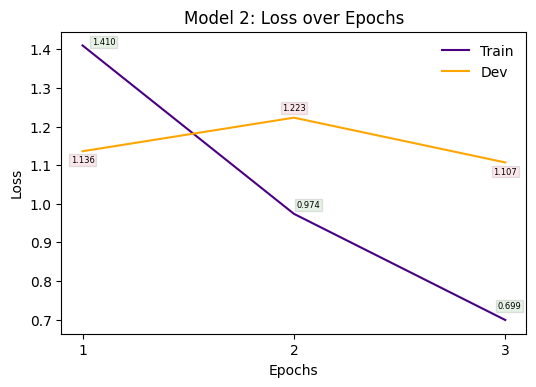

In [ ]:
def plot_loss_graph(title):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ticks = [1, 2, 3]
    train_loss = [1.410, 0.974, 0.699]
    dev_loss = [1.136, 1.223, 1.107]
    plt.xticks(ticks)

    plt.plot(ticks, train_loss, label='Train', color='indigo')
    plt.plot(ticks, dev_loss, label='Dev', color='orange')

    for idx, (a, b) in enumerate(zip(ticks, train_loss)):

        if idx == 0:
            ax.text(a+0.1, b-0.002, '1.410', fontsize=6, bbox={'facecolor': 'green', 'alpha': 0.1, 'pad': 1},
                    verticalalignment='bottom', horizontalalignment='center')
        else:
            if idx == 1:
                ax.text(a + 0.07, b + 0.012, str(b), fontsize=6, bbox={'facecolor': 'green', 'alpha': 0.1, 'pad': 1},
                        verticalalignment='bottom', horizontalalignment='center')
            else:
                if idx == 2:
                    ax.text(a+0.02, b + 0.025, str(b), fontsize=6,
                            bbox={'facecolor': 'green', 'alpha': 0.1, 'pad': 1},
                            verticalalignment='bottom', horizontalalignment='center')

    for idx, (a, b) in enumerate(zip(ticks, dev_loss)):

        if idx == 0:
            ax.text(a, b - 0.035, str(b), fontsize=6, bbox={'facecolor': 'crimson', 'alpha': 0.1, 'pad': 1},
                    verticalalignment='bottom', horizontalalignment='center')
        else:
            if idx == 1:
                ax.text(a, b + 0.014, '1.223', fontsize=6, bbox={'facecolor': 'crimson', 'alpha': 0.1, 'pad': 1},
                        verticalalignment='bottom', horizontalalignment='center')
            else:
                if idx == 2:
                    ax.text(a, b - 0.035, str(b), fontsize=6,
                            bbox={'facecolor': 'crimson', 'alpha': 0.1, 'pad': 1},
                            verticalalignment='bottom', horizontalalignment='center')

    plt.legend(frameon=False)
    plt.savefig("Model2 Loss.png", dpi=192)
    fig.set_dpi(100)
    plt.show()

plot_loss_graph("Model 2: Loss over Epochs")

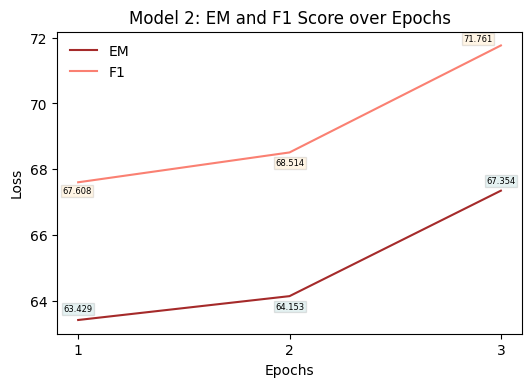

In [ ]:
def plot_score_graph(title):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ticks = [1, 2, 3]
    EM = [63.429,64.153,67.354]
    F1 = [67.608,68.514, 71.761]

    plt.xticks(ticks)

    plt.plot(ticks, EM, label='EM', color='brown')
    plt.plot(ticks, F1, label='F1', color='salmon')

    for idx, (a, b) in enumerate(zip(ticks, EM)):

        if idx == 0:
            ax.text(a, b + 0.2, str(b), fontsize=6, bbox={'facecolor': 'teal', 'alpha': 0.1, 'pad': 1},
                    verticalalignment='bottom', horizontalalignment='center')
        else:
            if idx == 1:
                ax.text(a , b - 0.45, str(b), fontsize=6, bbox={'facecolor': 'teal', 'alpha': 0.1, 'pad': 1},
                        verticalalignment='bottom', horizontalalignment='center')
            else:
                if idx == 2:
                    ax.text(a, b + 0.15, str(b), fontsize=6,
                            bbox={'facecolor': 'teal', 'alpha': 0.1, 'pad': 1},
                            verticalalignment='bottom', horizontalalignment='center')

    for idx, (a, b) in enumerate(zip(ticks, F1)):

        if idx == 0:
            ax.text(a - 0.005, b - 0.4, str(b), fontsize=6, bbox={'facecolor': 'orange', 'alpha': 0.1, 'pad': 1},
                    verticalalignment='bottom', horizontalalignment='center')
        else:
            if idx == 1:
                ax.text(a, b - 0.45, str(b), fontsize=6, bbox={'facecolor': 'orange', 'alpha': 0.1, 'pad': 1},
                        verticalalignment='bottom', horizontalalignment='center')
            else:
                if idx == 2:
                    ax.text(a-0.11, b+0.05, str(b), fontsize=6,
                            bbox={'facecolor': 'orange', 'alpha': 0.1, 'pad': 1},
                            verticalalignment='bottom', horizontalalignment='center')

    plt.legend(frameon=False)
    plt.savefig("Model2 Score.png", dpi=192)
    fig.set_dpi(100)
    plt.show()

plot_score_graph("Model 2: EM and F1 Score over Epochs")